In [100]:
# fixing import error using: https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2
import tensorflow.python.keras.layers
import tensorflow.python.keras.models
# https://blog.paperspace.com/autoencoder-image-compression-keras/
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 300

In [101]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

In [102]:
latent_dim_small_dim = 2
x = tensorflow.keras.layers.Input(shape=(IMG_SIZE**2), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=latent_dim_small_dim, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

In [103]:
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

In [104]:
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 90000)]           0         
                                                                 
 encoder_dense_1 (Dense)     (None, 300)               27000300  
                                                                 
 encoder_leakyrelu_1 (Leaky  (None, 300)               0         
 ReLU)                                                           
                                                                 
 encoder_dense_2 (Dense)     (None, 2)                 602       
                                                                 
 encoder_output (LeakyReLU)  (None, 2)                 0         
                                                                 
Total params: 27000902 (103.00 MB)
Trainable params: 27000902 (103.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [105]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_dim_small_dim), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=IMG_SIZE**2, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

In [106]:
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

In [107]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_dense_1 (Dense)     (None, 300)               900       
                                                                 
 decoder_leakyrelu_1 (Leaky  (None, 300)               0         
 ReLU)                                                           
                                                                 
 decoder_dense_2 (Dense)     (None, 90000)             27090000  
                                                                 
 decoder_output (LeakyReLU)  (None, 90000)             0         
                                                                 
Total params: 27090900 (103.34 MB)
Trainable params: 27090900 (103.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [108]:
# AE
ae_input = tensorflow.keras.layers.Input(shape=(IMG_SIZE**2), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")

In [109]:
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 90000)]           0         
                                                                 
 encoder_model (Functional)  (None, 2)                 27000902  
                                                                 
 decoder_model (Functional)  (None, 90000)             27090900  
                                                                 
Total params: 54091802 (206.34 MB)
Trainable params: 54091802 (206.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
import tensorflow.python.keras.optimizers  
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

In [111]:
from sklearn.model_selection import train_test_split
# usage of train-test-split
x_train, x_test = train_test_split(preprocessed_images_centered, test_size=10, random_state=42)

In [112]:
ae.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0268 - val_loss: 0.0293
Epoch 2/20
1/1 [==============================] - 0s 340ms/step - loss: 0.0268 - val_loss: 0.0293
Epoch 3/20
1/1 [==============================] - 0s 316ms/step - loss: 0.0268 - val_loss: 0.0293
Epoch 4/20
1/1 [==============================] - 0s 249ms/step - loss: 0.0268 - val_loss: 0.0293
Epoch 5/20
1/1 [==============================] - 0s 231ms/step - loss: 0.0268 - val_loss: 0.0293
Epoch 6/20
1/1 [==============================] - 0s 230ms/step - loss: 0.0268 - val_loss: 0.0293
Epoch 7/20
1/1 [==============================] - 0s 252ms/step - loss: 0.0268 - val_loss: 0.0292
Epoch 8/20
1/1 [==============================] - 0s 243ms/step - loss: 0.0268 - val_loss: 0.0292
Epoch 9/20
1/1 [==============================] - 0s 238ms/step - loss: 0.0267 - val_loss: 0.0291
Epoch 10/20
1/1 [==============================] - 0s 243ms/step - loss: 0.0266 - val_loss: 0.0288
Epoch 11/20
1/1 [=====

In [113]:
from math import dist as euclidean_distance
# plot squared error on validation set
def plot_prediction_err(x_test, ae, title='Squared error on validation set'):
    x_test_pred = ae.predict(x_test)
    x_residuals = [euclidean_distance(x_pred, x) for x_pred, x in zip(x_test_pred, x_test)]
    plt.plot(x_residuals, label="squared error")
    plt.legend()
    plt.title(title)
    plt.show()

# plot decoded images and originals
def plot_pred_real_img(x_test, ae):
    x_test_pred = ae.predict(x_test)
    n = len(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(x_test[i - 1].reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(x_test_pred[i - 1].reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

1/1 [==============================] - 0s 39ms/step


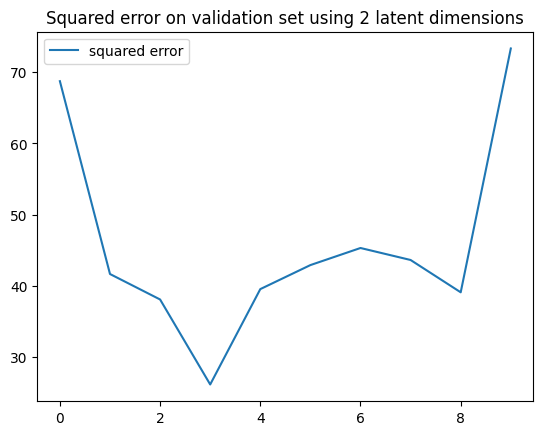

In [114]:
plot_prediction_err(x_test, ae, title=f'Squared error on validation set using {latent_dim_small_dim} latent dimensions')

1/1 [==============================] - 0s 20ms/step


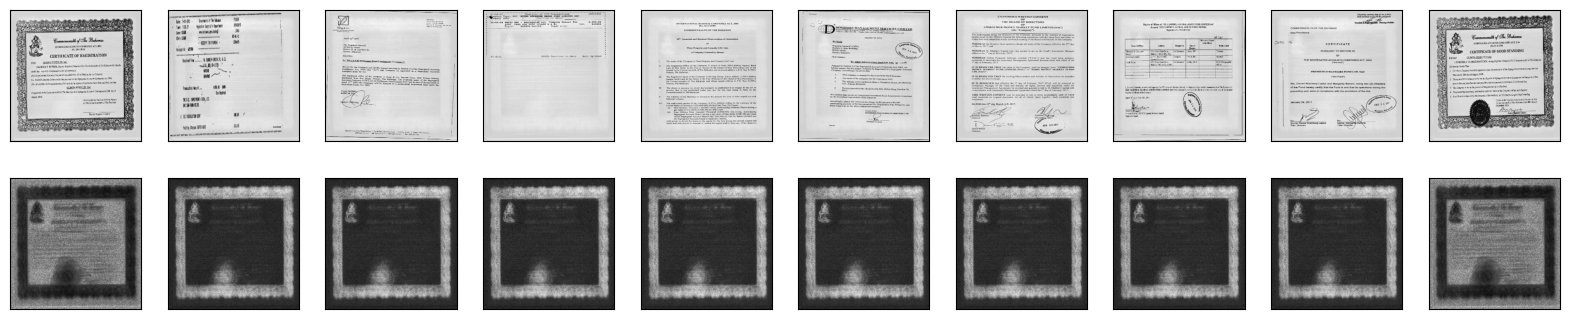

In [115]:
plot_pred_real_img(x_test, ae)

In [116]:
# encode (compress) and decode (reconstruct) all images
encoded_images = encoder.predict(preprocessed_images_centered)
decoded_images = decoder.predict(encoded_images)

7/7 [==============================] - 0s 5ms/step


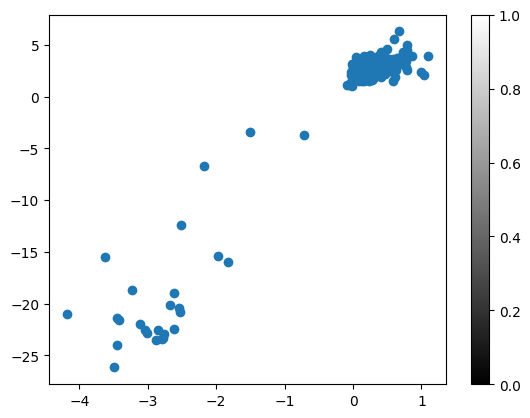

In [117]:
plt.figure()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
plt.colorbar()

In [118]:
# save representation of images
ae_2d_df = pd.DataFrame({'path': image_paths, 'ae': 0})
ae_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    ae_2d_df.loc[[image_paths[i]], 'ae'] = pd.Series([encoded_images[i]], index=ae_2d_df.index[[i]])

ae_2d_df

,ae
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[0.52806205, 2.5031285]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[0.17886066, 2.755469]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[-1.51143, -3.428651]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[0.15359105, 2.1688833]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[0.46710342, 3.2555642]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[0.41051272, 2.6596088]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.006593791, 2.209361]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[0.4077514, 1.9607502]"


In [119]:
NUM_CLASSES = 4
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(ae_2d_df['ae'].to_list())
ae_2d_df['cluster'] = d2_kmeans.labels_
display(ae_2d_df)

,ae,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[0.52806205, 2.5031285]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[0.17886066, 2.755469]",2
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[-1.51143, -3.428651]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[0.15359105, 2.1688833]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[0.46710342, 3.2555642]",2
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[0.41051272, 2.6596088]",2
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.006593791, 2.209361]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[0.4077514, 1.9607502]",0


Text(0.5, 1.0, 'AE latent space 2D representation of images clustered by KMeans')

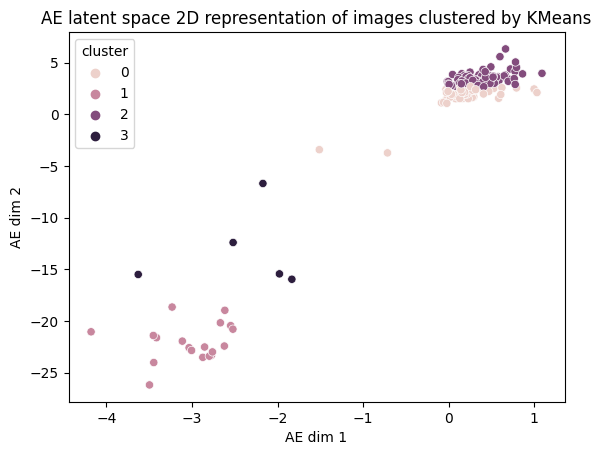

In [120]:
sns.scatterplot(x=ae_2d_df['ae'].apply(lambda x: x[0]), y=ae_2d_df['ae'].apply(lambda x: x[1]), hue=ae_2d_df['cluster'])
plt.xlabel('AE dim 1')
plt.ylabel('AE dim 2')
plt.title('AE latent space 2D representation of images clustered by KMeans')

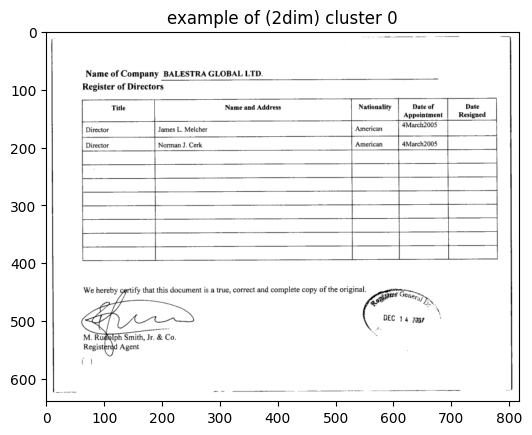

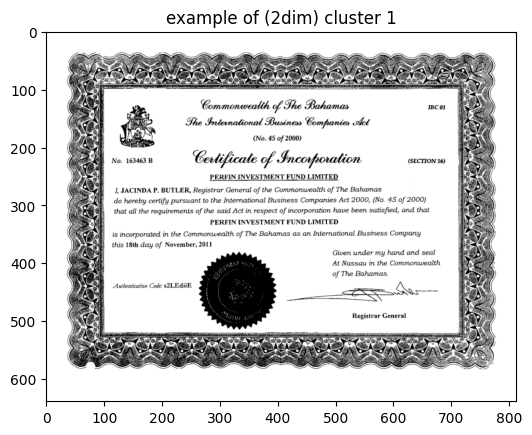

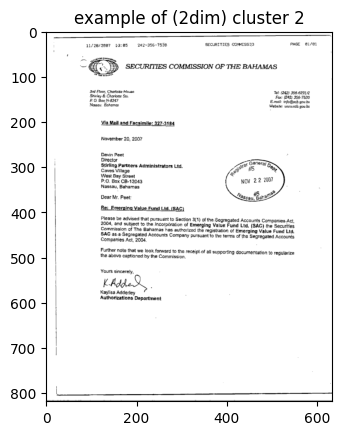

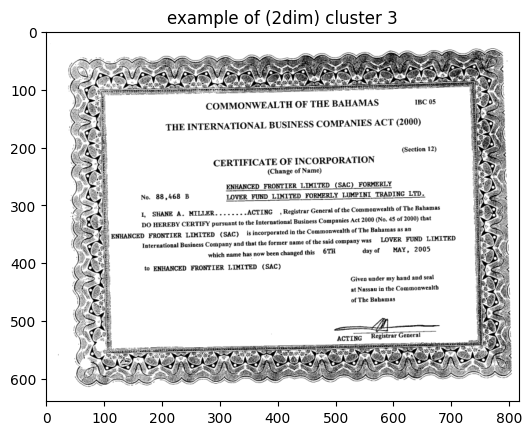

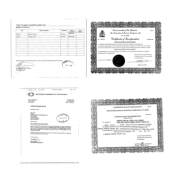

In [121]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = ae_2d_df[ae_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

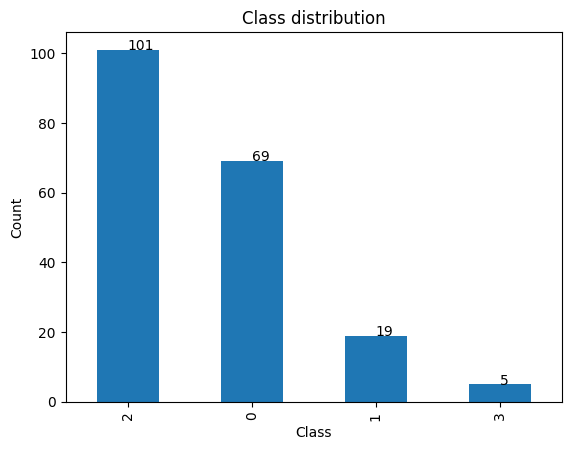

In [122]:
# class/ cluster distribution -> worse since train, test usage
ae_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = ae_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(ae_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])

#### AE with higher dimensionality in latent space

In [123]:
input_shape = IMG_SIZE**2
latent_dim_higher_dim = 100

In [124]:
# Encoder
x_higher_dim = tensorflow.keras.layers.Input(shape=(input_shape), name="encoder_input")

encoder_dense_layer1_higher_dim = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x_higher_dim)
encoder_activ_layer1_higher_dim = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1_higher_dim)

encoder_dense_layer2_higher_dim = tensorflow.keras.layers.Dense(units=latent_dim_higher_dim, name="encoder_dense_2")(encoder_activ_layer1_higher_dim)
encoder_output_higher_dim = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2_higher_dim)

encoder_higher_dim = tensorflow.keras.models.Model(x_higher_dim, encoder_output_higher_dim, name="encoder_model")
# encoder.summary()

# Decoder
decoder_input_higher_dim = tensorflow.keras.layers.Input(shape=(latent_dim_higher_dim), name="decoder_input")

decoder_dense_layer1_higher_dim = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input_higher_dim)
decoder_activ_layer1_higher_dim = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1_higher_dim)

decoder_dense_layer2_higher_dim = tensorflow.keras.layers.Dense(units=input_shape, name="decoder_dense_2")(decoder_activ_layer1_higher_dim)
decoder_output_higher_dim = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2_higher_dim)

decoder_higher_dim = tensorflow.keras.models.Model(decoder_input_higher_dim, decoder_output_higher_dim, name="decoder_model")
# decoder.summary()

# Autoencoder
ae_input_higher_dim = tensorflow.keras.layers.Input(shape=(input_shape), name="AE_input")
ae_encoder_output_higher_dim = encoder(ae_input_higher_dim)
ae_decoder_output_higher_dim = decoder(ae_encoder_output_higher_dim)

ae_higher_dim = tensorflow.keras.models.Model(ae_input_higher_dim, ae_decoder_output_higher_dim, name="AE")
# ae.summary()

# AE Compilation
ae_higher_dim.compile(loss="mse", optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.0005))

In [125]:
# data set, TODO: split into train and test
x_train, x_test = train_test_split(preprocessed_images_centered, test_size=10, random_state=42)

# Training AE
ae_higher_dim.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0230 - val_loss: 0.0253
Epoch 2/20
1/1 [==============================] - 0s 250ms/step - loss: 0.0228 - val_loss: 0.0252
Epoch 3/20
1/1 [==============================] - 0s 227ms/step - loss: 0.0226 - val_loss: 0.0250
Epoch 4/20
1/1 [==============================] - 0s 301ms/step - loss: 0.0225 - val_loss: 0.0250
Epoch 5/20
1/1 [==============================] - 0s 243ms/step - loss: 0.0224 - val_loss: 0.0251
Epoch 6/20
1/1 [==============================] - 0s 243ms/step - loss: 0.0224 - val_loss: 0.0251
Epoch 7/20
1/1 [==============================] - 0s 313ms/step - loss: 0.0223 - val_loss: 0.0251
Epoch 8/20
1/1 [==============================] - 0s 231ms/step - loss: 0.0223 - val_loss: 0.0252
Epoch 9/20
1/1 [==============================] - 0s 222ms/step - loss: 0.0223 - val_loss: 0.0252
Epoch 10/20
1/1 [==============================] - 0s 224ms/step - loss: 0.0223 - val_loss: 0.0253
Epoch 11/20
1/1 [=====

1/1 [==============================] - 0s 37ms/step


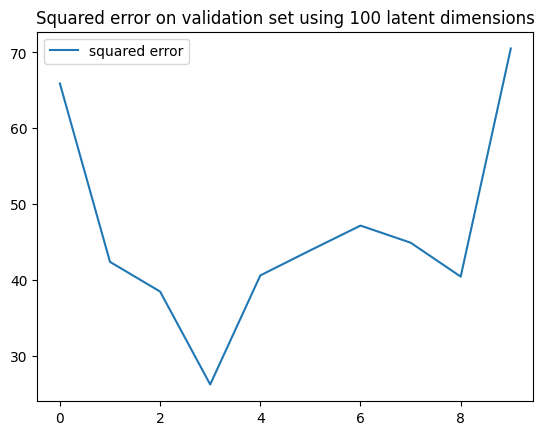

In [127]:
plot_prediction_err(x_test, ae_higher_dim, title=f'Squared error on validation set using {latent_dim_higher_dim} latent dimensions')

1/1 [==============================] - 0s 19ms/step


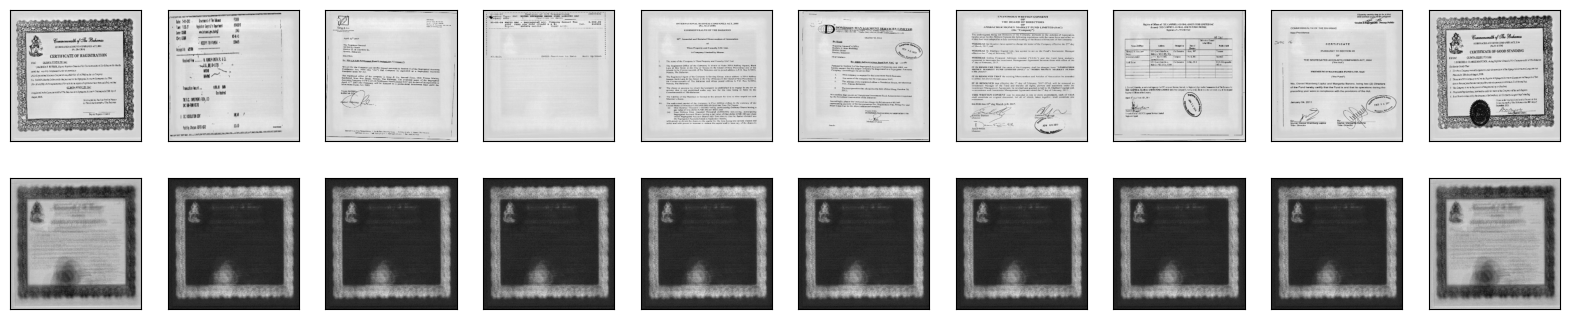

In [128]:
plot_pred_real_img(x_test, ae_higher_dim)

use PCA to reduce dimensionality of latent space and visualize

In [131]:
ae_encoded_images = encoder_higher_dim.predict(preprocessed_images_centered)
d2_ae_pca = decomposition.PCA(n_components=2, svd_solver="randomized", whiten=True)
pca_2d_ae_img = d2_ae_pca.fit_transform(ae_encoded_images)

7/7 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'AE-PCA 2D representation of images clustered by KMeans on PCA components')

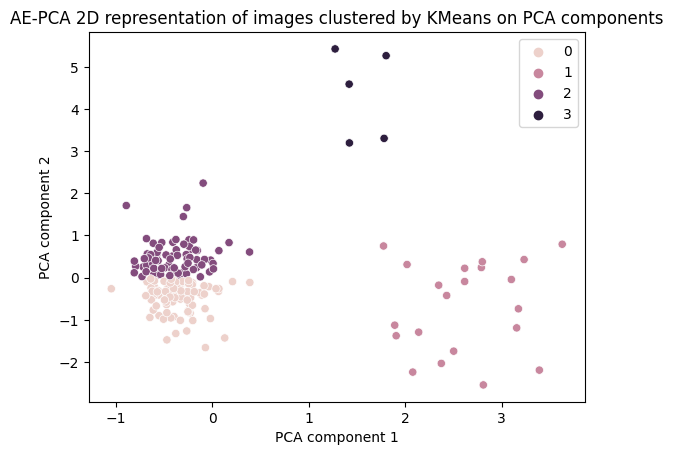

In [135]:
d2_ae_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_2d_ae_img)
sns.scatterplot(x=pca_2d_ae_img[:,0], y=pca_2d_ae_img[:,1], hue=d2_ae_kmeans.labels_)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('AE-PCA 2D representation of images clustered by KMeans on PCA components')

Text(0.5, 1.0, 'AE-PCA 2D representation of images clustered by KMeans on AE latent space')

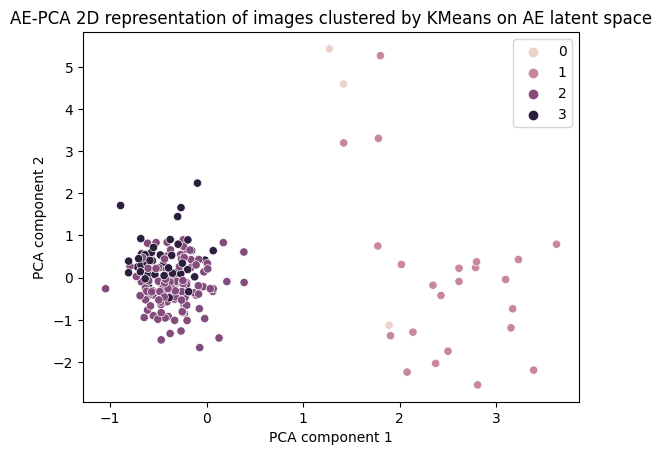

In [137]:
d2_ae_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(ae_encoded_images)
sns.scatterplot(x=pca_2d_ae_img[:,0], y=pca_2d_ae_img[:,1], hue=d2_ae_kmeans.labels_)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('AE-PCA 2D representation of images clustered by KMeans on AE latent space')

### Convolutional Autoencoder
for more information see: https://keras.io/examples/vision/autoencoder/

In [164]:
IMG_SIZE_SMALL = IMG_SIZE

In [169]:

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMG_SIZE_SMALL, IMG_SIZE_SMALL, 1))
    return array


def display(array1, array2=None):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :] if array2 is not None else images1

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1) if array2 is not None else plt.subplot(1, n, i + 1)
        plt.imshow(image1.reshape(IMG_SIZE_SMALL, IMG_SIZE_SMALL))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if image2 is not None:
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(image2.reshape(IMG_SIZE_SMALL, IMG_SIZE_SMALL))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

In [167]:
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE_SMALL, IMG_SIZE_SMALL)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE_SMALL**2) 
        for img in image_paths])

/var/folders/hk/dwphr0p14vn00wrnlw8bxjpw0000gn/T/ipykernel_7467/1128382760.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, n, i + 1 + n)


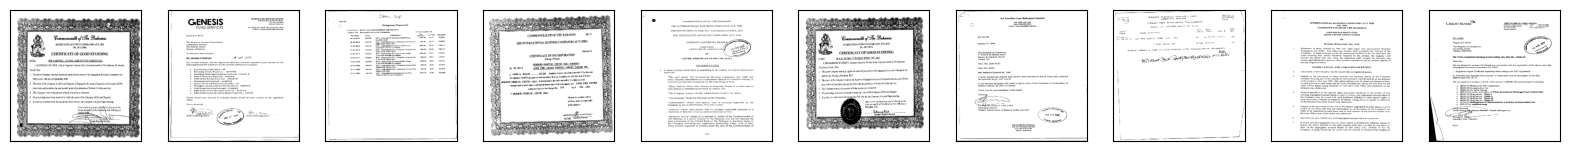

In [170]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
train_data, test_data = train_test_split(preprocessed_images, test_size=10, random_state=42)

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Display the train data and a version of it with added noise
display(train_data)


In [171]:
input = tensorflow.keras.layers.Input(shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 1))

# Encoder
x = tensorflow.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
x = tensorflow.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tensorflow.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = tensorflow.keras.Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 150, 150, 32)      0         
 g2D)                                                            


                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 150, 150, 32)      9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 300, 300, 32)      9248      
 Transpose)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 300, 300, 1)       289       
                                                                 
Total params: 28353 (110.75 KB)
Trainable params: 28353 (110.75 KB)
Non-trai

In [172]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
2/2 [==============================] - 7s 2s/step - loss: 0.6928 - val_loss: 0.6902
Epoch 2/50
2/2 [==============================] - 6s 1s/step - loss: 0.6898 - val_loss: 0.6869
Epoch 3/50
2/2 [==============================] - 6s 1s/step - loss: 0.6864 - val_loss: 0.6831
Epoch 4/50
2/2 [==============================] - 6s 1s/step - loss: 0.6825 - val_loss: 0.6788
Epoch 5/50
2/2 [==============================] - 6s 1s/step - loss: 0.6780 - val_loss: 0.6737
Epoch 6/50
2/2 [==============================] - 6s 1s/step - loss: 0.6728 - val_loss: 0.6678
Epoch 7/50
2/2 [==============================] - 6s 1s/step - loss: 0.6668 - val_loss: 0.6610
Epoch 8/50
2/2 [==============================] - 6s 1s/step - loss: 0.6598 - val_loss: 0.6529
Epoch 9/50
2/2 [==============================] - 6s 1s/step - loss: 0.6514 - val_loss: 0.6431
Epoch 10/50
2/2 [==============================] - 6s 1s/step - loss: 0.6414 - val_loss: 0.6314
Epoch 11/50
2/2 [==============================] 

1/1 [==============================] - 0s 119ms/step


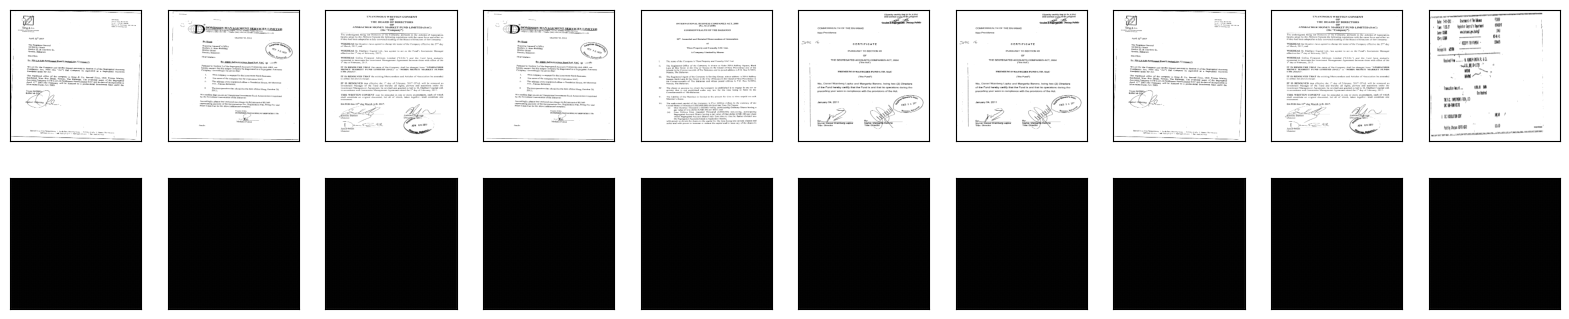

In [173]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

### Compare both 2 dim and 100 dim AEs

1/1 [==============================] - 0s 21ms/step


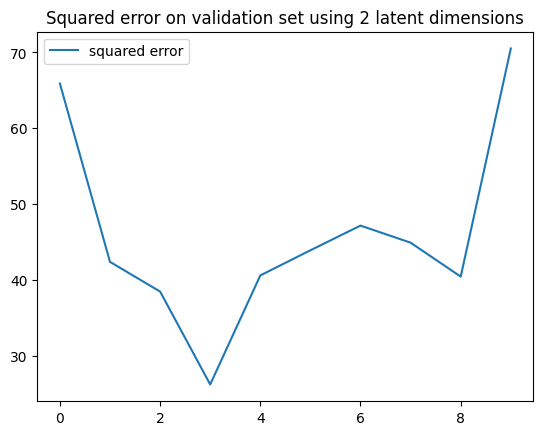

1/1 [==============================] - 0s 19ms/step


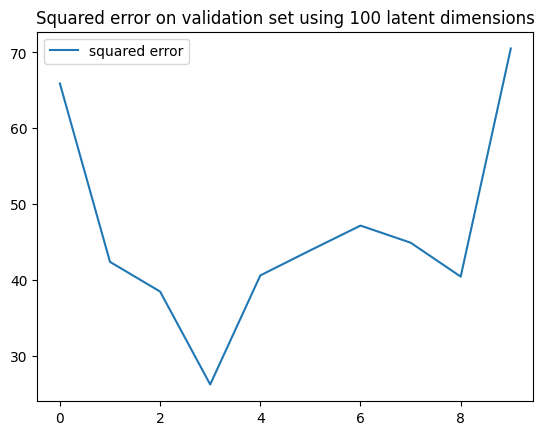

In [129]:
plot_prediction_err(x_test, ae, title=f'Squared error on validation set using {latent_dim_small_dim} latent dimensions')
plot_prediction_err(x_test, ae_higher_dim, title=f'Squared error on validation set using {latent_dim_higher_dim} latent dimensions')